# Evaluation of Forecasts

**Authors:**
- Adriano P. Almeida (adriano.almeida@inpe.br)
- Alan J. P. Calheiros (alan.calheiros@inpe.br)

## Table of Contents
1. Introduction
2. Dataset Description
3. Experimental Setup
4. Data Loading and Preprocessing
5. Forecast Visualization
6. Performance Metrics
7. Statistical Evaluation
8. Performance Diagram Construction
9. Mathematical Appendix
10. References

---

## 1. Introduction

This notebook provides an evaluation for **precipitation nowcasting** models over **Latin America**. It compares several deep learning architectures trained to forecast hourly precipitation using satellite-based data. The evaluation includes deterministic and categorical verification metrics, such as Probability of Detection (POD), False Alarm Ratio (FAR), and Critical Success Index (CSI), along with visual diagnostics like performance diagrams.

The architectures evaluated are:

- **Persistence** (baseline model)
- **RIKEN Deep Learning Nowcast (baseline model)**
- **AFNO** (Adaptive Fourier Neural Operator)
- **InceptionV4**
- **ResNet**
- **Xception**

Each model produces precipitation forecasts at several lead times (1–6 hours), and these outputs are compared against the observed precipitation fields.

---

## 2. Dataset Description

The datasets are stored in **NetCDF format** and organized by architecture and forecast horizon:

```
../data/dl-nowcasting-precipitation-latam/<Architecture>/FSCT<horizon>/*.nc
```

Each NetCDF file contains at least two key variables:

- `precip_obs`: observed precipitation (ground truth)
- `precip_fct`: forecast precipitation (model prediction)

The data spans the Latin American domain with approximate spatial bounds:
- Latitude: -55° to 33°
- Longitude: -120° to -24°

---

## 3. Experimental Setup

### Input Configuration
- **Spatial domain:** 0.1° × 0.1° grid.
- **Temporal resolution:** 1 hour.
- **Forecast horizons:** 1 to 6 hours.
- **Precipitation thresholds:** 0.1, 1.0, 5.0, and 10.0 mm/h.

### Libraries
The evaluation uses the following key Python libraries:
- `xarray` — for multi-dimensional data handling.
- `matplotlib` & `cartopy` — for visualization.
- `numpy` & `pandas` — for statistical computation and tabular management.

In [1]:
import pathlib
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from matplotlib.lines import Line2D

In [2]:
# ============================================================
# Global settings
# ============================================================
base_path = pathlib.Path("../data/dl-nowcating-precipitation-latam")

lat_min, lat_max = -55.0, 33.0
lon_min, lon_max = -120.0, -24.0

architectures = [
    "Persistence",
    "Riken",
    "AFNO",
    "InceptionV4",
    "ResNet",
    "Xception"
]
horizons = [1, 2, 3, 4, 5, 6]
thresholds = [0.1, 1.0, 5.0, 10.0]

---

## 4. Data Loading and Preprocessing

The notebook defines a modular function to load all forecast horizons for a given architecture:

In [3]:
def load_architecture_datasets(architecture: str, horizons: list[int]) -> xr.Dataset:
    """Load and concatenate all forecast horizons for a given model architecture."""
    datasets = []
    for horizon in horizons:
        pattern = base_path / architecture / f"FSCT{horizon}" / "*.nc"
        files = sorted(pattern.parent.glob(pattern.name))
        if not files:
            continue
        ds = xr.open_mfdataset(
            [f.as_posix() for f in files],
            combine="by_coords",
            preprocess=lambda ds: ds.drop_dims("run", errors="ignore")
        )
        ds = ds.assign_coords(horizon=horizon)
        datasets.append(ds)
    return xr.concat(datasets, dim="horizon") if datasets else None

Each dataset is concatenated along the `horizon` dimension, allowing easy selection and visualization later.

---

## 5. Forecast Visualization

To visually compare model outputs against ground truth, the notebook provides the function `plot_forecast_comparison()`:

In [4]:
def plot_forecast_comparison(datasets, architecture, time, horizon):
    """Plota comparação entre observação e previsão para uma arquitetura e horizonte."""
    if architecture not in datasets:
        raise ValueError(f"Arquitetura '{architecture}' não encontrada nos datasets carregados.")
    
    ds = datasets[architecture]
    if horizon not in ds.horizon.values:
        raise ValueError(f"Horizonte {horizon}h não encontrado para '{architecture}'.")

    fig, ax = plt.subplots(
        1, 2, 
        subplot_kw={"projection": ccrs.PlateCarree()}, 
        figsize=(10, 6)
    )

    for i, ax_ in enumerate(ax.flat):
        ax_.set_extent([lon_min, lon_max, lat_min, lat_max])
        ax_.add_feature(cfeature.COASTLINE)
        ax_.add_feature(cfeature.BORDERS, linestyle=":")
        gl = ax_.gridlines(draw_labels=True, linestyle="--", alpha=0.5, linewidth=0.5, color="gray")
        gl.top_labels = False
        if i % 2 == 0:
            gl.right_labels = False
        else:
            gl.left_labels = False

    vmin, vmax = 0, 20
    ds.sel(horizon=horizon, time=time)["precip_obs"].plot(
        ax=ax[0],
        cmap="Blues",
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs={"label": "Precipitation (mm)", "shrink": 0.5, "pad": 0.15}
    )
    ds.sel(horizon=horizon, time=time)["precip_fct"].plot(
        ax=ax[1],
        cmap="Blues",
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs={"label": "Precipitation (mm)", "shrink": 0.5, "pad": 0.15}
    )

    ax[0].set_title("Ground Truth", y=1.05, fontsize=14)
    ax[0].set_title(f"{time} (+{horizon}h)", loc="right", fontsize=7, y=0.99)
    ax[1].set_title(f"{architecture} Forecast", y=1.05, fontsize=14)
    ax[1].set_title(f"{time} (+{horizon}h)", loc="right", fontsize=7, y=0.99)
    plt.tight_layout()
    plt.show()


This function plots side-by-side panels showing:
1. **Ground Truth (Observed Precipitation)**
2. **Model Forecast**

Each map includes coastlines, borders, and gridlines, and uses a consistent color scale (`Blues`) for precipitation intensity (0–20 mm/h).

### Example Usage

In [5]:
# Create a dictionary to hold datasets for each architecture
datasets = {}
for arch in architectures:
    print(f"Carregando arquitetura: {arch}")
    ds = load_architecture_datasets(arch, horizons)
    if ds is not None:
        datasets[arch] = ds

print(f"\nArquiteturas carregadas: {list(datasets.keys())}")

Carregando arquitetura: Persistence
Carregando arquitetura: Riken
Carregando arquitetura: AFNO
Carregando arquitetura: InceptionV4
Carregando arquitetura: ResNet
Carregando arquitetura: Xception

Arquiteturas carregadas: ['Persistence', 'Riken', 'AFNO', 'InceptionV4', 'ResNet', 'Xception']


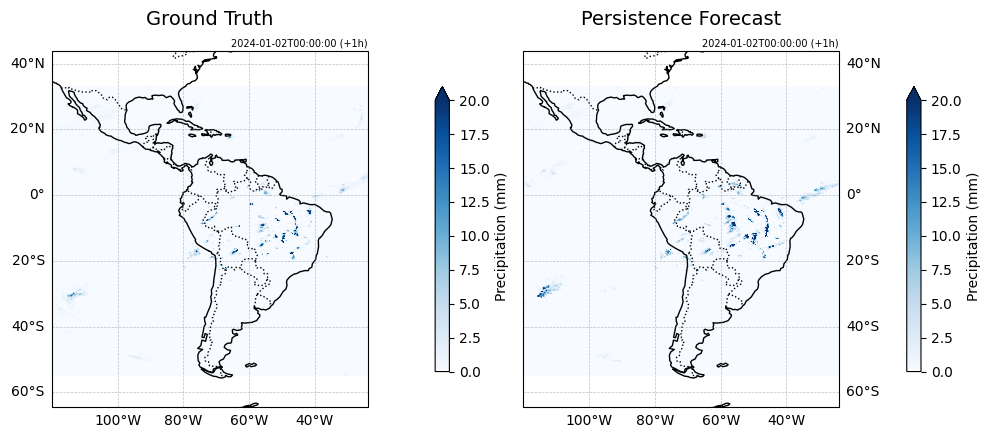

In [6]:
plot_forecast_comparison(datasets, architecture="Persistence", time="2024-01-02T00:00:00", horizon=1)

---

## 6. Performance Metrics

Three categorical metrics are used to assess forecast quality across precipitation thresholds:

### 6.1. Contingency Table Components

Each forecast–observation pair is categorized into four possible outcomes:

| Term | Meaning | Formula |
|------|----------|----------|
| TP | True Positive | forecast ≥ threshold and obs ≥ threshold |
| FP | False Positive | forecast ≥ threshold and obs < threshold |
| FN | False Negative | forecast < threshold and obs ≥ threshold |
| TN | True Negative | forecast < threshold and obs < threshold |

### 6.2. Derived Metrics

Mathematically:

$
\text{POD} = \frac{TP}{TP + FN}
$

$
\text{FAR} = \frac{FP}{TP + FP}
$

$
\text{CSI} = \frac{TP}{TP + FP + FN}
$

Where:
- **POD (Probability of Detection):** measures the fraction of observed events correctly predicted.
- **FAR (False Alarm Ratio):** quantifies overforecasting tendency.
- **CSI (Critical Success Index):** combines hits and errors into one unified measure.

These metrics are computed for each architecture, horizon, and threshold.

In [7]:
# ============================================================
# Functions to compute metrics
# ============================================================
def compute_contingency(obs, fct, threshold):
    """Computes the contingency table components: TP, FP, FN, TN."""
    
    obs_bin = obs >= threshold
    fct_bin = fct >= threshold

    TP = np.logical_and(fct_bin, obs_bin).sum()
    FP = np.logical_and(fct_bin, np.logical_not(obs_bin)).sum()
    FN = np.logical_and(np.logical_not(fct_bin), obs_bin).sum()
    TN = np.logical_and(np.logical_not(fct_bin), np.logical_not(obs_bin)).sum()
    return TP, FP, FN, TN


def compute_metrics(TP, FP, FN):
    """Computes POD, FAR, and CSI from contingency table components."""
    pod = TP / (TP + FN) if (TP + FN) > 0 else np.nan
    far = FP / (TP + FP) if (TP + FP) > 0 else np.nan
    csi = TP / (TP + FP + FN) if (TP + FP + FN) > 0 else np.nan
    return pod, far, csi
    
results = []

for arch in architectures:
    print(f"Loading architectures: {arch}")
    ds = load_architecture_datasets(arch, horizons)
    if ds is None:
        continue

    for horizon in horizons:
        if horizon not in ds.horizon.values:
            continue

        for thr in thresholds:
            obs = ds.sel(horizon=horizon)["precip_obs"].values
            fct = ds.sel(horizon=horizon)["precip_fct"].values

            # Ignora NaNs
            mask = np.isfinite(obs) & np.isfinite(fct)
            obs_valid = obs[mask]
            fct_valid = fct[mask]

            # Computa métricas
            TP, FP, FN, TN = compute_contingency(obs_valid, fct_valid, thr)
            pod, far, csi = compute_metrics(TP, FP, FN)

            results.append({
                "architecture": arch,
                "horizon": horizon,
                "threshold": thr,
                "POD": pod,
                "FAR": far,
                "CSI": csi
            })
            
df_metrics = pd.DataFrame(results)
print(df_metrics.head())

Loading architectures: Persistence
Loading architectures: Riken
Loading architectures: AFNO
Loading architectures: InceptionV4
Loading architectures: ResNet
Loading architectures: Xception
  architecture  horizon  threshold       POD       FAR       CSI
0  Persistence        1        0.1  0.494609  0.417460  0.365174
1  Persistence        1        1.0  0.550480  0.581359  0.311985
2  Persistence        1        5.0  0.569821  0.658618  0.271429
3  Persistence        1       10.0  0.531791  0.713619  0.228713
4  Persistence        2        0.1  0.402283  0.539768  0.273326


---

## 7. Statistical Evaluation

The results are stored in a Pandas DataFrame with the following structure:

| Architecture | Horizon | Threshold | POD | FAR | CSI |
|---------------|----------|------------|------|------|------|

This table enables easy filtering, aggregation, and visualization across multiple model–threshold combinations.

### Example Plot — CSI vs Horizon



This plot reveals how performance degrades with increasing lead time and varies across model architectures.

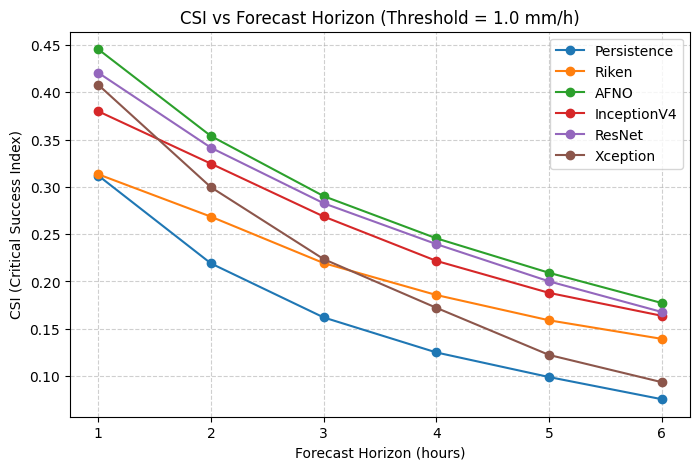

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))
for arch in architectures:
    subset = df_metrics[(df_metrics["architecture"] == arch) & (df_metrics["threshold"] == 1.0)]
    ax.plot(subset["horizon"], subset["CSI"], marker="o", label=arch)

ax.set_xlabel("Forecast Horizon (hours)")
ax.set_ylabel("CSI (Critical Success Index)")
ax.set_title("CSI vs Forecast Horizon (Threshold = 1.0 mm/h)")
ax.grid(True, linestyle="--", alpha=0.6)
ax.legend()
plt.show()

---

## 8. Performance Diagram Construction

The **performance diagram** jointly visualizes POD, Success Ratio (SR = 1 − FAR), CSI, and Bias.

### 8.1. Diagram Background

The background grid contains contours for CSI and lines for Bias:

$
CSI = \frac{1}{(1/POD) + (1/SR) - 1}
$

The Bias lines (dotted) represent overforecasting (>1) or underforecasting (<1) regimes.

### 8.2. Multi-Panel Visualization

Each subplot corresponds to a different precipitation threshold (0.1, 1.0, 5.0, 10.0 mm/h). Within each subplot:
- Lines connect horizons for each architecture.
- Marker shapes denote forecast lead times.
- Colors identify model architectures.

This visualization allows intuitive interpretation of detection ability, reliability, and overall skill.

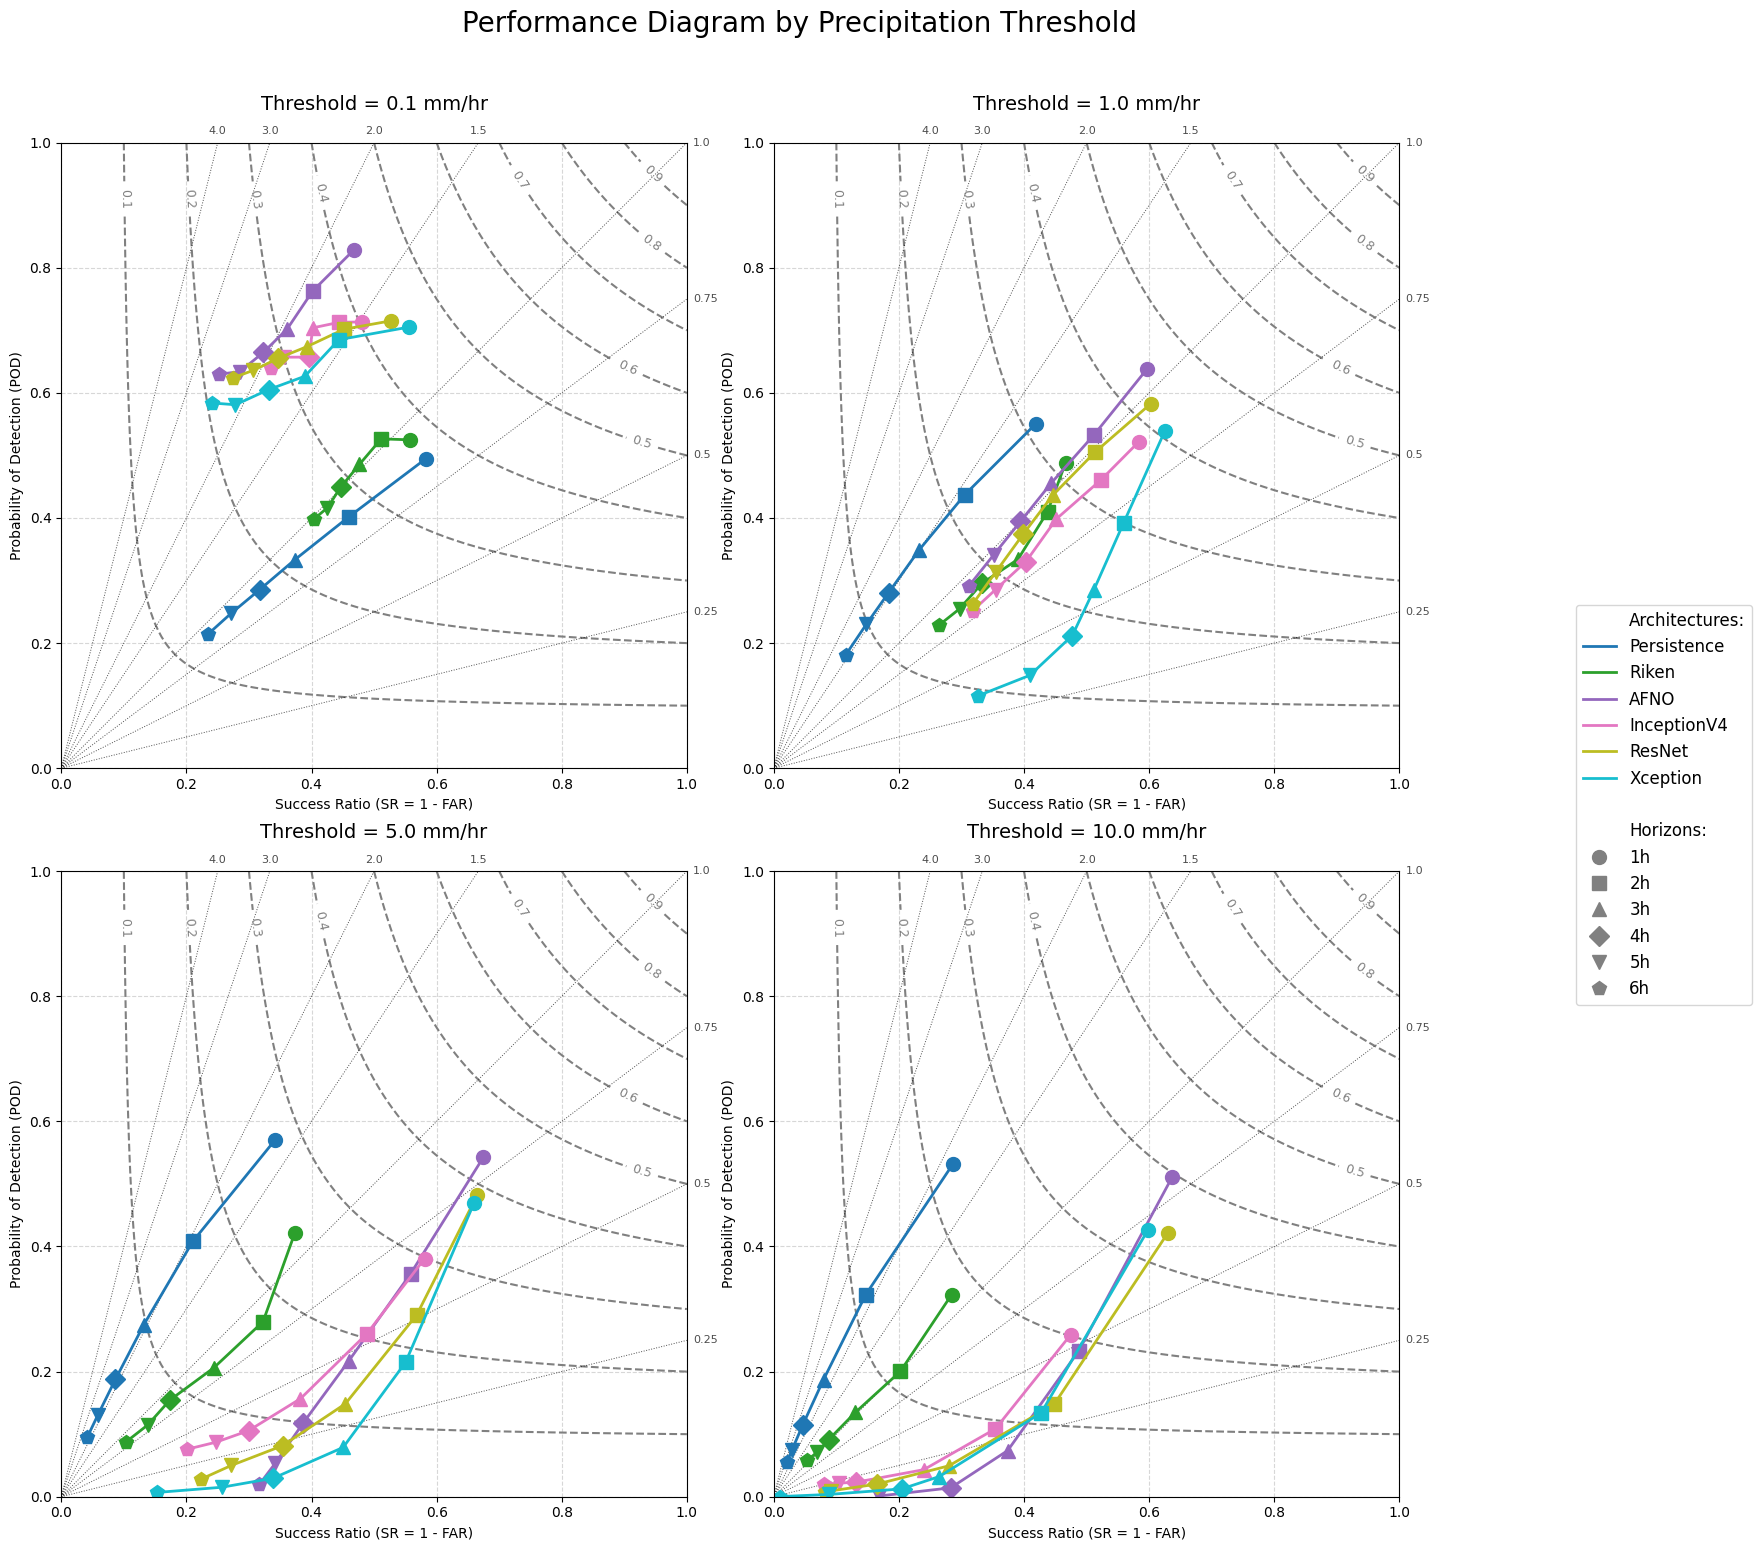

In [12]:
# --- 2. Function to draw the diagram background (SAME AS BEFORE) ---
def plot_performance_diagram_background(ax):
    """
    Draws the background of the Performance Diagram with CSI contours
    and Bias lines.
    """
    s_range = np.linspace(0.01, 1, 100)  # Success Ratio (SR)
    p_range = np.linspace(0.01, 1, 100)  # POD
    sr_grid, pod_grid = np.meshgrid(s_range, p_range)

    with np.errstate(divide='ignore'):
        csi_grid = 1.0 / (1.0 / pod_grid + 1.0 / sr_grid - 1.0)
    csi_grid[csi_grid < 0] = np.nan

    csi_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    csi_contours = ax.contour(sr_grid, pod_grid, csi_grid, levels=csi_levels, colors='gray', linestyles='dashed')
    ax.clabel(csi_contours, inline=True, fontsize=9, fmt='%.1f')

    bias_levels = [0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 4.0]
    for b in bias_levels:
        if b <= 1:
            ax.plot([0, 1], [0, b], color='black', linestyle=':', linewidth=0.7, alpha=0.7)
            ax.text(1.01, b, f'{b}', va='center', ha='left', fontsize=8, color='black', alpha=0.7)
        else:
            ax.plot([0, 1/b], [0, 1], color='black', linestyle=':', linewidth=0.7, alpha=0.7)
            ax.text(1/b, 1.01, f'{b}', va='bottom', ha='center', fontsize=8, color='black', alpha=0.7)

    ax.set_xlabel('Success Ratio (SR = 1 - FAR)', fontsize=10)
    ax.set_ylabel('Probability of Detection (POD)', fontsize=10)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal', 'box')
    ax.grid(True, linestyle='--', alpha=0.5)


# --- 3. Data Preparation and Grid Plotting ---

# Calculate the Success Ratio (SR)
df_metrics['SR'] = 1 - df_metrics['FAR']

# Define the thresholds to plot
plot_thresholds = [0.1, 1.0, 5.0, 10.0]

# Create the figure with 4 subplots (2x2)
fig, axes = plt.subplots(2, 2, figsize=(16, 15))
# 'axes.ravel()' flattens the 2x2 grid into a 1D array to make looping easier
axes_flat = axes.ravel()

# Define color palette for architectures and markers for horizons
architectures = df_metrics['architecture'].unique()
horizons = sorted(df_metrics['horizon'].unique())

# Colors
arch_colors = plt.cm.tab10(np.linspace(0, 1, len(architectures)))
color_map = dict(zip(architectures, arch_colors))

# Markers
horizon_markers = ['o', 's', '^', 'D', 'v', 'p', '*']
marker_map = dict(zip(horizons, horizon_markers[:len(horizons)]))

# --- Main loop: 1 iteration per subplot ---
for i, threshold in enumerate(plot_thresholds):
    ax = axes_flat[i]
    
    # Draw the background (CSI, Bias)
    plot_performance_diagram_background(ax)
    ax.set_title(f'Threshold = {threshold} mm/hr', fontsize=14, pad=10, y=1.03)

    # Filter the data for this threshold only
    df_thresh = df_metrics[df_metrics['threshold'] == threshold]

    # Loop over each architecture (to draw the lines)
    for arch in architectures:
        # Get the data for this architecture, sorted by horizon
        df_arch = df_thresh[df_thresh['architecture'] == arch].sort_values('horizon')
        
        if not df_arch.empty:
            sr = df_arch['SR']
            pod = df_arch['POD']
            
            # Plot the line connecting the horizons
            ax.plot(sr, pod, 
                    color=color_map[arch], 
                    linestyle='-', 
                    linewidth=2)
            
            # Plot the individual markers for each horizon
            for horizon in horizons:
                df_point = df_arch[df_arch['horizon'] == horizon]
                if not df_point.empty:
                    ax.plot(df_point['SR'], df_point['POD'],
                            marker=marker_map[horizon],
                            color=color_map[arch],
                            markersize=10,
                            linestyle='None') # No line, just the marker

# --- 4. Creating a custom Legend for the entire Figure ---
legend_elements = []

# Add elements for Architecture (color)
legend_elements.append(Line2D([0], [0], color='gray', lw=0, label='Architectures:'))
for arch, color in color_map.items():
    legend_elements.append(Line2D([0], [0], color=color, lw=2, label=arch))

# Add a spacer
legend_elements.append(Line2D([0], [0], color='gray', lw=0, label=''))

# Add elements for Horizon (marker)
legend_elements.append(Line2D([0], [0], color='gray', lw=0, label='Horizons:'))
for horizon, marker in marker_map.items():
     legend_elements.append(Line2D([0], [0], marker=marker, color='gray', 
                                   label=f'{horizon}h', markerfacecolor='gray', 
                                   markersize=10, linestyle='None'))

# Add the legend to the right side of the figure
fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0.98, 0.5), fontsize=12)

# Add an overall title
fig.suptitle('Performance Diagram by Precipitation Threshold', fontsize=20, y=1.03)

# Adjust the layout so the legend and title are not clipped
plt.tight_layout(rect=[0, 0, 0.9, 1.01]) # Leave space on the right and top
plt.show()

---

## 9. Mathematical Appendix

### 9.1. Derivation of the Critical Success Index (CSI)

Starting from the contingency table:

$
\text{Total} = TP + FP + FN + TN
$

The **CSI** focuses only on events (ignoring true negatives):
$
CSI = \frac{TP}{TP + FP + FN}
$

It can also be expressed in terms of **POD** and **Success Ratio (SR)**:
$
CSI = \frac{1}{\frac{1}{POD} + \frac{1}{SR} - 1}
$
where \( SR = 1 - FAR \).

### 9.2. Bias Calculation

Bias quantifies the ratio between forecast and observed events:
$
\text{Bias} = \frac{TP + FP}{TP + FN}
$

Interpretation:
- Bias = 1 → perfect balance between predicted and observed events.
- Bias > 1 → overforecasting (too many predicted events).
- Bias < 1 → underforecasting (too few predicted events).

### 9.3. Relationship between POD, FAR, and CSI

Combining definitions:
$
\text{POD} = \frac{TP}{TP + FN}, \quad \text{FAR} = \frac{FP}{TP + FP}
$

Substituting into CSI gives:
$
CSI = \frac{POD \times (1 - FAR)}{1 - FAR \times POD}
$

This equation shows the trade-off: increasing POD tends to increase FAR, and CSI captures this balance.

### 9.4. Example Values

| POD | FAR | SR | CSI | Bias |
|-----|-----|----|-----|------|
| 0.8 | 0.2 | 0.8 | 0.67 | 1.0 |
| 0.6 | 0.1 | 0.9 | 0.55 | 0.78 |
| 0.4 | 0.4 | 0.6 | 0.29 | 0.67 |

---

## 10. References

- Wilks, D. S. (2011). *Statistical Methods in the Atmospheric Sciences*. Academic Press.
- Hogan, R. J., & Mason, I. B. (2012). Deterministic forecasts of binary events. *Meteorological Applications*, 19(1), 45–59.
- Schaefer, J. T. (1990). The Critical Success Index as an indicator of forecast skill. *Weather and Forecasting*, 5(4), 570–575.
- Schultz, D. M., & Tewari, M. (2021). Can machine learning improve weather forecasts? *Bulletin of the American Meteorological Society*, 102(4), E716–E729.
- Kubota, T. et al. (2020). Global Satellite Mapping of Precipitation (GSMaP): Algorithm updates and products. *IEEE Transactions on Geoscience and Remote Sensing*, 58(7), 3911–3924.